In [1]:
#import modules
import xarray as xr
import numpy as np
import pandas as pd
import salem
import plotly.graph_objects as go

import sys
sys.path.append('/exports/csce/datastore/geos/users/s1878599/python_code/')
from WRFChemToolkit.analysis import aerosols_202 as aer, plots as pt, statistics as st, IGP as igp

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Get IGP data for each season
#Get IGP data for each season
aut_pth='/geos/d21/s1878599/IGP/sims_0304_2020/outputs/autumn/base/wrfout*.nc'
win_pth='/geos/d21/s1878599/IGP/sims_0304_2020/outputs/winter/wrfout*.nc'
mon_pth='/geos/d21/s1878599/IGP/sims_0304_2020/outputs/monsoon/wrfout*.nc'
pmon_pth='/geos/d21/s1878599/IGP/sims_0304_2020/outputs/premonsoon/wrfout*'

shp_path =  '/exports/csce/datastore/geos/users/s1878599//python_code/gadm_data/IGP/IGP.shp'

aIGP =igp.get_IGP(aut_pth, shp_path)
wIGP =igp.get_IGP(win_pth, shp_path)
mIGP =igp.get_IGP(mon_pth, shp_path)
pmIGP =igp.get_IGP(pmon_pth, shp_path)

In [3]:
#Get time and space vars for each IGP administration

def get_tsm_IGP(dict):
    tsaer_IGP={}
    for adm, val in dict.items():
        tsaer_IGP.update({adm : st.space_mean(st.time_mean(val,"time"))})
    return tsaer_IGP

In [4]:
a= get_tsm_IGP(aIGP)
w= get_tsm_IGP(wIGP)
m= get_tsm_IGP(mIGP)
pm= get_tsm_IGP(pmIGP)

In [5]:
#Get time vars for each IGP administration

def get_tm_IGP(dict):
    t_IGP={}
    for adm, val in dict.items():
        t_IGP.update({adm : st.time_mean(val,"time")})
    return t_IGP

In [24]:
at= get_tm_IGP(aIGP)
wt= get_tm_IGP(wIGP)
mt= get_tm_IGP(mIGP)
pmt= get_tm_IGP(pmIGP)

In [7]:
#define precurors classes

def get_aromatics(d):
    for adm, val in d.items():
        val["arom"]=val.tol + val.benzene + val.xyl    
        val.arom.attrs["units"] ="ppmv"
    
def get_monoterpenes(d):
    for adm, val in d.items():
        val["monot"]=val.apin + val.bpin + val.limon  
        val.monot.attrs["units"] ="ppmv"
    
def get_nox(d):
    for adm, val in d.items():
        val["nox"]=val.no + val.no2 
        val.nox.attrs["units"] ="ppmv"


In [8]:
#get surface values 
def get_sval(d, vname):
    sval={}
    for adm, val in d.items():
         sval.update({adm : val[vname].values[0]})
    return sval

In [9]:
get_nox(m)
get_nox(pm)
get_nox(a)
get_nox(w)

nox_m =get_sval(m,"nox")
nox_a =get_sval(a,"nox")
nox_w =get_sval(w,"nox")
nox_pm =get_sval(pm,"nox")


In [25]:
get_nox(mt)
get_nox(pmt)
get_nox(at)
get_nox(wt)

In [ ]:
# Get precursors values 

#mmono_u=get_sval(mt,"monot")
#maro_u=get_sval(mt,"arom")
#malk_u=get_sval(mt,"bigalk")
#mene_u=get_sval(mt,"bigene")
#misop_u=get_sval(mt,"isopr")

In [10]:
def plot_precursors(pm,m,a,w,title,colors,ylabel="ppmv",sf=1):

    data = {
    "upper":[pm["U_IGP"]*sf,m["U_IGP"]*sf,a["U_IGP"]*sf,w["U_IGP"]*sf],
    "middle":[pm["M_IGP"]*sf,m["M_IGP"]*sf,a["M_IGP"]*sf,w["M_IGP"]*sf],
    "lower": [pm["L_IGP"]*sf,m["L_IGP"]*sf,a["L_IGP"]*sf,w["L_IGP"]*sf],
    "labels": [
        "Premonsoon",
        "Monsoon",
        "Autumn",
        "Winter",
    ]
    }

    fig = go.Figure(
    data=[
        go.Bar(
            name="Upper IGP",
            x=data["labels"],
            y=data["upper"],
            marker_color=colors[0],            
            offsetgroup=0,
        ),
        go.Bar(
            name="Middle IGP",
            x=data["labels"],
            y=data["middle"],
             marker_color= colors[1], 
            offsetgroup=1,
        ),
        go.Bar(
            name="Lower IGP",
            x=data["labels"],
            y=data["lower"],
            marker_color=colors[2],
            offsetgroup=2,
        )
    ],
    layout=go.Layout(
        title_text=title, title_x=0.5,
        yaxis_title=ylabel
    )
    )

    fig.show()

In [14]:
col=["rgb(76,0,153)","rgb(153,0,153)","rgb(178,102,255)"]
plot_precursors(nox_pm,nox_m,nox_a,nox_w, colors=col, ylabel="ppbv", title="$NO_x$",sf=1e3)

In [15]:
#SPATIAL PLOT IGP

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.colorbar import colorbar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader

def set_formatter(axes):
    for ax in axes:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.5, color='k', alpha=0.4, linestyle='-')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 7, 'color': 'gray'}
        gl.ylabel_style = {'size': 7, 'color': 'grey'} 

        
def set_admin(axes, shp_path):
    for ax,shp in zip(axes,shp_path):
            admin = list(shpreader.Reader(shp).geometries())
            # Add data from Global Administrative Areas Dataset GDAM https://gadm.org/index.html
            ax.add_geometries(admin, ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', alpha=1, lw=0.75)
    

def subIGP(lat,lon,pmds,mds,ads,wds,vmax=None, title=None, label=None, cmap="OrRd", levs=10, figsize=[10, 10],format="%.2f"):

    fig, axes =plt.subplots(nrows=4,ncols=1,figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})
    igp_shp="/exports/csce/datastore/geos/users/s1878599/python_code/gadm_data/IGP/IGP.shp"
    shp_path=(igp_shp,igp_shp,igp_shp,igp_shp)
    
    set_formatter(axes.flatten())
    set_admin(axes.flatten(), shp_path)
    
    #Getting values.
    vpm=pmds[0,:,:].values
    vm= mds[0,:,:].values
    va= ads[0,:,:].values
    vw= wds[0,:,:].values
    if not vmax is None:  # set vmax in the bar to a fixed costumed value (useful to compare consitently different plots).
        vmax=vmax  
    else: 
        import math                # Get the max value in the array to plot.
        vmax =np.array([np.nanmax(vpm),np.nanmax(vm),np.nanmax(va),np.nanmax(vw)]).max()       
       
    vmin=0
    print(vmax)
    levels = np.linspace(vmin, vmax, levs)  # number of levels for which divide the bar. Customised. 
    
    # premonsoon
    cspm=axes[0].contourf(lon,lat,vpm,transform=ccrs.PlateCarree(),cmap=cmap,levels=levels,vmin=vmin,vmax=vmax) #U IGP values.
                                                 
    # monsoon
    csm=axes[1].contourf(lon,lat,vm,transform=ccrs.PlateCarree(),cmap=cmap,levels=levels,vmin=vmin,vmax=vmax) #U IGP values.
    #autumn
    csa=axes[2].contourf(lon,lat,va,transform=ccrs.PlateCarree(),cmap=cmap,levels=levels,vmin=vmin,vmax=vmax) #U IGP values.
    #winter
    csw=axes[3].contourf(lon,lat,vw,transform=ccrs.PlateCarree(),cmap=cmap,levels=levels, vmin=vmin,vmax=vmax) #U IGP values.
    
 
    axes[0].text(-0.25, 0.55, 'PREMONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=axes[0].transAxes)
    axes[1].text(-0.25, 0.55, 'MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=axes[1].transAxes)
    axes[2].text(-0.25, 0.55, 'AUTUMN', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=axes[2].transAxes)
    axes[3].text(-0.25, 0.55, 'WINTER', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=axes[3].transAxes)
    
    #set colorbar
    cax, kw= mpl.colorbar.make_axes([ax for ax in axes.flat], orientation="horizontal", pad=0.035,shrink=.45, format=format)
    cbar=fig.colorbar(csa, cax=cax, **kw)
    if label is not None:
        cbar.set_label(label)
    if title is not None:
        axes[0].set_title(title, fontsize=12,pad=20)
    fig.tight_layout()
    fig.show()

In [26]:
lon =at["IGP"].lon.values[:,:]
lat =at["IGP"].lat.values[:,:]

450.40256


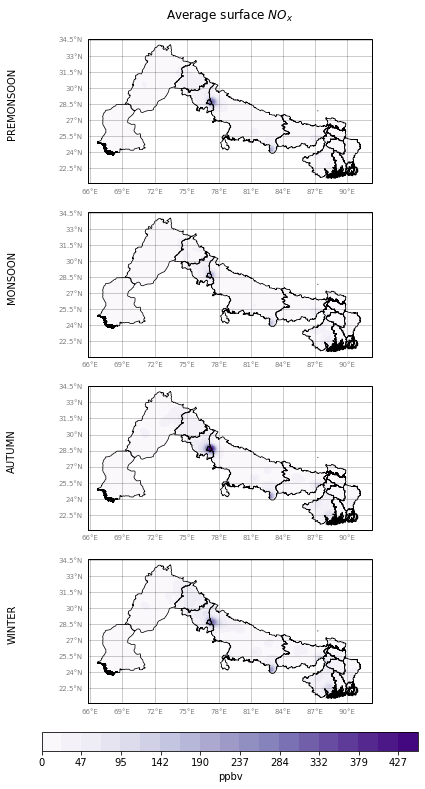

In [29]:
subIGP(lat,lon,pmt["IGP"].nox*1e3,mt["IGP"].nox*1e3,at["IGP"].nox*1e3,wt["IGP"].nox*1e3, title="Average surface $NO_x$", cmap="Purples", levs=20, label="ppbv", figsize=[15,15],format="%.f")

In [30]:
# Put oxidants values in a matrix TODO create a function that take in a variable and put out table with seasonal average values
#in a pandas dataframe
import pandas as pd

data= {'season': ["premonsoon","premonsoon","premonsoon","monsoon","monsoon","monsoon","autumn","autumn","autumn","winter","winter","winter"],
        'area': ["upper","middle","lower","upper","middle","lower","upper","middle","lower","upper","middle","lower"],
        'NOx (ppbv)':[nox_pm["U_IGP"]*1e3,nox_pm["M_IGP"]*1e3,nox_pm["L_IGP"]*1e3,nox_m["U_IGP"]*1e3,nox_m["M_IGP"]*1e3,nox_m["L_IGP"]*1e3,nox_a["U_IGP"]*1e3,nox_a["M_IGP"]*1e3,nox_a["L_IGP"]*1e3,nox_w["U_IGP"]*1e3,nox_w["M_IGP"]*1e3,nox_w["L_IGP"]*1e3],
        }
f = pd.DataFrame (data, columns = ["season","area", 'NOx (ppbv)'])


In [31]:
f

,season,area,NOx (ppbv)
0,premonsoon,upper,9.972323
1,premonsoon,middle,24.794679
2,premonsoon,lower,12.782271
3,monsoon,upper,7.907952
4,monsoon,middle,16.844086
5,monsoon,lower,15.640048
6,autumn,upper,14.464073
7,autumn,middle,32.572892
8,autumn,lower,22.286313
9,winter,upper,16.244337


In [26]:
f.to_csv("/exports/csce/datastore/geos/users/s1878599/oxi_igp.csv")